# Assignment #2

Please follow instruction below to complete your assingment.
You are expected to provide:
- data files
- IPython notebook

Please use code blocks to comment and explain your code.

STUDENT ID: 30715

In [1]:
%matplotlib inline
import gzip
import json
import numpy as np
import random

import matplotlib.pyplot as plt

import networkx as nx

# Import any other package you may need

In [2]:
class Agent(object):

  def __init__(self, id, state):
    self.id = id
    self.states = [[0, state]]


  def updateState(self, newState, timestamp=None):
    if timestamp == None:
      self.states.append([len(self.states), newState])
    else:
      self.states.append([timestamp, newState])

  def currentState(self):
    return self.states[-1][1]

  def __str__(self):
    return "Agent {} is in state '{}'".format(self.id, self.currentState())

agent = Agent(0, "S")
agent.updateState("I")
print(agent)

Agent 0 is in state 'I'


In [32]:
class SimulationSI(object):

    def __init__(self, agents, network, mu):
        self.agents = agents
        self.network = network
        self.mu = mu
        self.timestamp = 0
        self.stateCounts = dict()
        stateCount = dict()
        for agent in self.agents.values():
            cstate = agent.currentState()
            if cstate not in stateCount:
                stateCount[cstate] = 0
            stateCount[cstate] += 1
        self.stateCounts[self.timestamp] = stateCount

    def step(self):
      self.timestamp += 1
      newInfections = []

      infectedAgents = [agent for agent in self.agents.values() if agent.currentState() == "I"]

      for agent in infectedAgents:
          neighbors = list(self.network.neighbors(agent.id))
          for n in neighbors:
              neighborAgent = self.agents[n]
              if neighborAgent.currentState() == "S":
                  if random.random() < self.mu:
                      newInfections.append(neighborAgent)

      for agent in newInfections:
          agent.updateState("I", self.timestamp)

      stateCount = dict()
      for agent in self.agents.values():
          cstate = agent.currentState()
          if cstate not in stateCount:
              stateCount[cstate] = 0
          stateCount[cstate] += 1
      self.stateCounts[self.timestamp] = stateCount

    def getStateFractions(self):
      stateFracs = list()
      for t in range(self.timestamp):
          sumV = sum(list(self.stateCounts[t].values()))
          s = self.stateCounts[t]["S"] if "S" in self.stateCounts[t] else 0
          i = self.stateCounts[t]["I"] if "I" in self.stateCounts[t] else 0
          stateFracs.append([s / sumV, i / sumV])
      return np.array(stateFracs)





Graph with 500 nodes and 6289 edges


Text(0, 0.5, 'Fraction of agents')

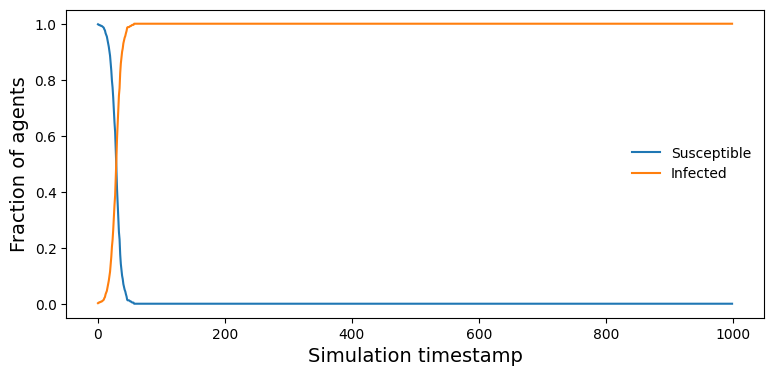

In [57]:
nAgents = 500
socialNet = nx.erdos_renyi_graph(nAgents, 0.05)
#socialNet = nx.barabasi_albert_graph(nAgents, 3)
print(socialNet)

agentDict = dict()
for n in socialNet.nodes():
  agentDict[n] = Agent(n, "S")
randNode = random.sample(list(agentDict.keys()), 1)[0]
agentDict[randNode] = Agent(randNode, "I")

simSI = SimulationSI(agentDict, socialNet, 0.01)
for t in range(1000):
  simSI.step()

temp = simSI.getStateFractions()
fig = plt.figure(figsize=(9,4))
plt.plot(temp[:,0], label="Susceptible")
plt.plot(temp[:,1], label="Infected")
plt.legend(frameon=False)
plt.xlabel("Simulation timestamp", fontsize=14)
plt.ylabel("Fraction of agents", fontsize=14)

In [43]:
class SimulationSIR(object):

    def __init__(self, agents, network, mu, gamma):
        self.agents = agents
        self.network = network
        self.mu = mu
        self.gamma = gamma
        self.timestamp = 0
        self.stateCounts = dict()
        stateCount = dict()
        for agent in self.agents.values():
            cstate = agent.currentState()
            if cstate not in stateCount:
                stateCount[cstate] = 0
            stateCount[cstate] += 1
        self.stateCounts[self.timestamp] = stateCount

    def step(self):
        self.timestamp += 1
        newInfections = []
        recoveries = []

        for agent in self.agents.values():
            if agent.currentState() == "I":
                # Infect susceptible neighbors
                neighbors = list(self.network.neighbors(agent.id))
                for n in neighbors:
                    neighborAgent = self.agents[n]
                    if neighborAgent.currentState() == "S":
                        if random.random() < self.mu:
                            newInfections.append(neighborAgent)

                # Possibly recover
                if random.random() < self.gamma:
                    recoveries.append(agent)

        for agent in newInfections:
            agent.updateState("I", self.timestamp)

        for agent in recoveries:
            agent.updateState("R", self.timestamp)

        stateCount = dict()
        for agent in self.agents.values():
            cstate = agent.currentState()
            if cstate not in stateCount:
                stateCount[cstate] = 0
            stateCount[cstate] += 1
        self.stateCounts[self.timestamp] = stateCount

    def getStateFractions(self):
        stateFracs = list()
        for t in range(self.timestamp):
            sumV = sum(list(self.stateCounts[t].values()))
            s = self.stateCounts[t]["S"] if "S" in self.stateCounts[t] else 0
            i = self.stateCounts[t]["I"] if "I" in self.stateCounts[t] else 0
            r = self.stateCounts[t]["R"] if "R" in self.stateCounts[t] else 0
            stateFracs.append([s / sumV, i / sumV, r / sumV])
        return np.array(stateFracs)


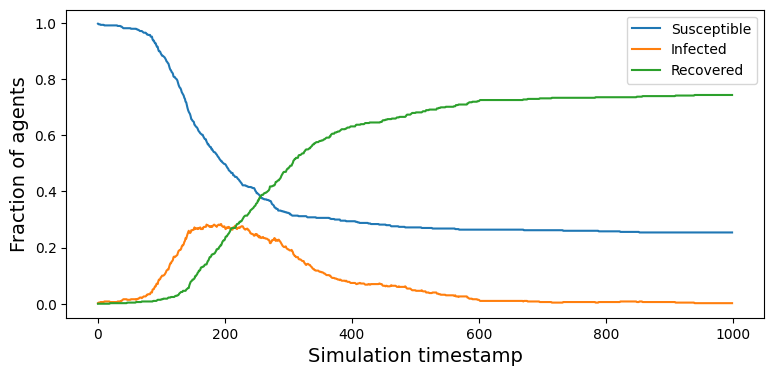

In [65]:
nAgents = 500
socialNet = nx.erdos_renyi_graph(nAgents, 0.05)
socialNet = nx.barabasi_albert_graph(nAgents, 3)

agentDict = dict()
for n in socialNet.nodes():
    agentDict[n] = Agent(n, "S")

randNode = random.sample(list(agentDict.keys()), 1)[0]
agentDict[randNode] = Agent(randNode, "I")

simSIR = SimulationSIR(agentDict, socialNet, mu=0.005, gamma=0.01)
for t in range(1000):
    simSIR.step()

fractions = simSIR.getStateFractions()
plt.figure(figsize=(9,4))
plt.plot(fractions[:, 0], label="Susceptible")
plt.plot(fractions[:, 1], label="Infected")
plt.plot(fractions[:, 2], label="Recovered")
plt.xlabel("Simulation timestamp", fontsize=14)
plt.ylabel("Fraction of agents", fontsize=14)
plt.legend()
plt.show()
